In [1]:
import os, sys
import pandas as pd
import numpy as np
import numpy.matlib
import scipy as sp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from pingouin import mediation_analysis

## Read in data

In [2]:
df_pheno = pd.read_csv('data/df_pheno.csv')
df_pheno.set_index(['bblid','scanid'], inplace = True)
df_pheno.head()

,,squeakycleanExclude,ageAtScan1,ageAtScan1_Years,sex,race2,handednessv2,dti64MeanAbsRMS,dti64MeanRelRMS,dti64MaxAbsRMS,dti64MaxRelRMS,mprage_antsCT_vol_TBV,averageManualRating,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
bblid,scanid,,,,,,,,,,,,,,,,,,
81287,2738,0,240,20.0,2,1,1,0.351665,0.154478,0.557358,0.272518,1.497389e+06,2.0,0.314394,-1.109349,-0.572468,1.222410,1.134094,-0.235063
80680,2739,1,253,21.1,1,1,1,0.531246,0.208078,0.754717,0.354560,1.813450e+06,2.0,0.748088,-0.905436,1.414109,0.032372,2.343126,0.744692
81754,2740,1,232,19.3,2,1,1,0.310943,0.218462,0.460633,0.387235,1.364954e+06,2.0,1.381240,0.986549,-0.969899,0.301802,-0.313214,-0.344655
81903,2749,0,231,19.2,2,1,1,0.432610,0.283153,0.819576,0.509537,1.266520e+06,2.0,0.531327,-0.885234,0.085093,1.994165,-0.831330,-1.902806
81043,2750,0,249,20.8,2,2,1,0.162409,0.096761,0.429102,0.259678,1.254653e+06,2.0,-0.330777,-0.788469,-0.798989,-2.036093,-0.072305,-0.746145


In [3]:
df_system = pd.read_csv('data/df_system.csv')
df_system.set_index(['bblid','scanid'], inplace = True)
df_system.head()

,,ct,jd,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,jd_8,jd_9,jd_10,jd_11,jd_12,jd_13,jd_14,jd_15,jd_16,jd_17
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,-0.244481,0.000682,-0.447502,-0.484110,-0.045826,-0.111647,-0.356220,-0.331039,-0.107237,-0.263501,...,-0.018313,0.059466,0.038632,-0.104141,-0.069048,-0.025119,0.033855,-0.005589,-0.012419,0.082375
80680,2739,-0.293535,-0.038376,-0.075566,-0.064355,-0.119455,-0.216842,-0.382597,-0.296695,-0.424994,-0.626117,...,-0.035643,-0.099134,-0.056971,-0.008471,-0.118097,-0.090080,-0.082227,-0.059138,0.031980,-0.055984
81754,2740,-0.115790,0.016437,0.155023,0.453592,-0.143237,-0.272653,-0.038651,-0.186689,-0.287686,-0.352952,...,-0.053909,-0.013814,-0.006453,0.057462,0.035556,-0.010350,-0.014886,-0.007110,-0.030681,-0.064011
81903,2749,-0.015776,-0.027930,-0.067138,-0.191562,0.118769,-0.160779,0.090528,0.025191,-0.088359,-0.248205,...,-0.047253,-0.054776,0.010141,-0.027603,-0.048177,0.058807,-0.034837,0.012315,0.026092,0.006368
81043,2750,0.045987,0.028378,-0.386811,-0.311837,-0.002629,0.262060,-0.096561,0.289440,0.041003,0.246226,...,-0.060398,-0.014248,0.004987,0.014552,0.067147,0.036815,-0.003796,0.030978,0.069522,0.109241


### X = scanageMonths | M = brain_t1 (yeo systems) | Y = pheno_t2

In [4]:
pheno = 'Overall_Psychopathology'; print(pheno)
metric = 'jd'; print(metric)

Overall_Psychopathology
jd


In [5]:
brain_preds = df_system.filter(regex = metric+'_')
mediators = list(brain_preds.columns)
df_input = pd.concat((df_pheno.loc[:,'ageAtScan1'],
                      brain_preds,
                      df_pheno.loc[:,pheno].rename('Y')), axis = 1) # combine
df_input.dropna(axis = 0, inplace = True)

df_input = (df_input - df_input.mean())/df_input.std() # standardize
df_input = pd.concat((df_input, df_pheno.loc[:,'sex']-1), axis = 1) # combine
df_input = sm.add_constant(df_input) # add constant term
df_input.dropna(axis = 0, inplace = True)

/Users/lindenmp/.virtualenvs/generic/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [6]:
df_input.head()

,,const,ageAtScan1,jd_1,jd_2,jd_3,jd_4,jd_5,jd_6,jd_7,jd_8,...,jd_10,jd_11,jd_12,jd_13,jd_14,jd_15,jd_16,jd_17,Y,sex
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,1.0,1.343722,-0.473098,0.809174,-1.139014,0.330024,0.582350,0.667398,0.699437,-0.379644,...,0.483957,-1.850405,-1.363269,-0.340321,0.612685,-0.138963,-0.234404,1.142092,0.180817,1
80680,2739,1.0,1.660731,-0.043750,2.693430,0.957822,-0.355782,-3.033320,-1.619304,-1.353140,-0.738933,...,-0.713695,-0.150518,-2.331673,-1.220410,-1.488062,-1.470418,0.603619,-0.776191,0.604528,0
81754,2740,1.0,1.148639,1.353373,1.282689,1.705970,-0.262483,0.083724,0.112448,0.036835,-1.117595,...,-0.080838,1.020989,0.702000,-0.140222,-0.269395,-0.176781,-0.579091,-0.887483,1.223106,1
81903,2749,1.0,1.124254,-0.275661,-0.558109,-0.660111,-1.902534,0.049704,-0.517309,-0.800610,-0.979612,...,0.127044,-0.490464,-0.951202,0.796729,-0.630449,0.306195,0.492489,0.088286,0.392756,1
81043,2750,1.0,1.563190,-0.610457,-0.294281,1.618487,0.204803,1.582181,0.903372,-0.081221,-1.252116,...,0.062468,0.258555,1.325730,0.498772,-0.068705,0.770247,1.312213,1.514578,-0.449503,1


In [7]:
med = mediation_analysis(data=df_input, x='ageAtScan1', m=mediators, y='Y', alpha=0.05, n_boot = 1000, seed=0)
med.set_index('path', inplace = True)

In [8]:
med.loc[med['sig'] == 'Yes',:]

,coef,se,pval,CI[2.5%],CI[97.5%],sig
path,,,,,,
jd_1 ~ X,-0.2100,0.0295,2.011012e-12,-0.2680,-0.1521,Yes
jd_3 ~ X,0.0736,0.0301,1.467221e-02,0.0145,0.1327,Yes
jd_4 ~ X,-0.0822,0.0301,6.378723e-03,-0.1413,-0.0232,Yes
jd_5 ~ X,-0.1892,0.0296,2.587356e-10,-0.2474,-0.1310,Yes
jd_6 ~ X,-0.1264,0.0299,2.622976e-05,-0.1852,-0.0677,Yes
jd_7 ~ X,-0.2965,0.0288,9.524890e-24,-0.3531,-0.2400,Yes
jd_8 ~ X,-0.4003,0.0277,1.488909e-43,-0.4546,-0.3460,Yes
jd_9 ~ X,-0.3923,0.0278,9.296446e-42,-0.4468,-0.3378,Yes
jd_11 ~ X,-0.2697,0.0291,9.040316e-20,-0.3267,-0.2127,Yes


In [9]:
np.round(med.filter(regex = 'Indirect', axis = 0).loc[med['sig'] == 'Yes',:], decimals=3)

,coef,se,pval,CI[2.5%],CI[97.5%],sig
path,,,,,,
Indirect jd_17,-0.017,0.009,0.046,-0.033,-0.001,Yes


In [10]:
med.loc['Direct',:]

coef              0.2702
se                 0.037
pval         5.55595e-13
CI[2.5%]          0.1976
CI[97.5%]         0.3428
sig                  Yes
Name: Direct, dtype: object

In [11]:
col = metric+'_17'
np.round(med.filter(regex = col, axis = 0), decimals=3)

,coef,se,pval,CI[2.5%],CI[97.5%],sig
path,,,,,,
jd_17 ~ X,-0.251,0.029,0.000,-0.308,-0.194,Yes
Y ~ jd_17,0.038,0.032,0.231,-0.024,0.101,No
Indirect jd_17,-0.017,0.009,0.046,-0.033,-0.001,Yes


/Users/lindenmp/.virtualenvs/generic/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


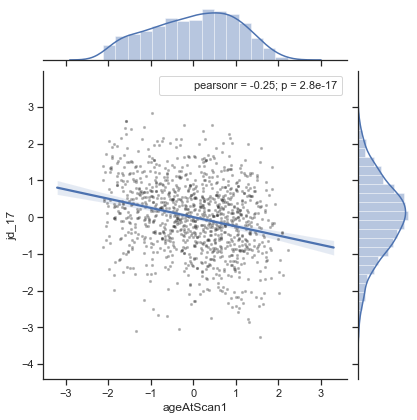

In [12]:
f = sns.jointplot(x = df_input.loc[:,'ageAtScan1'], y = df_input.loc[:,col], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

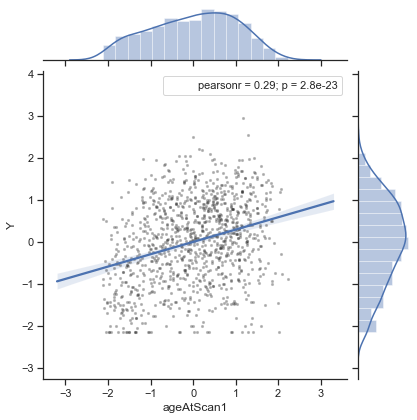

In [13]:
f = sns.jointplot(x = df_input.loc[:,'ageAtScan1'], y = df_input.loc[:,'Y'], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

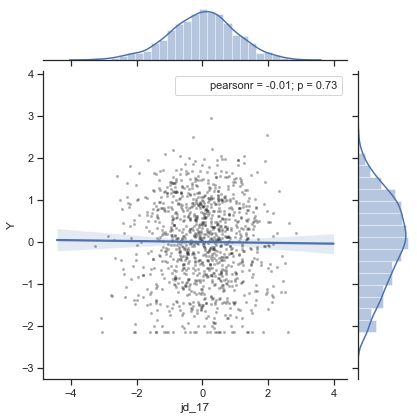

In [14]:
f = sns.jointplot(x = df_input.loc[:,col], y = df_input.loc[:,'Y'], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)